In [1]:
# Imports
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import least_squares
from matplotlib import pyplot as plt
import thyrohelpers as th
import pandas as pd
import os

Define repeated functions:
 - fillNaN: replaces NaN if present with interpolate of given order
 - dosing: input doseing regieme to return piecewise function $s(t)$ and values to plug into ODE solver. Recall $s(t) = c$ is the amount of MMI orally taken per day per liter of body volume (mg/L/day)

In [2]:
def fillNaN(df, order): return df.interpolate(method="polynomial", limit_direction="forward", order=order, inplace=False)
MMI_dose = lambda dose: (0.93 * dose[0][0] * dose[1][0])/59.71

Load patient data, fill NaN values with polynomial interpolate if necessary

In [3]:
patient20, patient31, patient55, patient70 = (
    os.path.join("patient_data", "patient 20.xlsx"),
    os.path.join("patient_data", "patient 31.xlsx"),
    os.path.join("patient_data", "patient 55.xlsx"),
    os.path.join("patient_data", "patient 70.xlsx"))

df20, df31, df55, df70 = (
    fillNaN(pd.read_excel(patient20), 3),
    fillNaN(pd.read_excel(patient31), 2),
    fillNaN(pd.read_excel(patient55), 2), 
    pd.read_excel(patient70))

In [4]:
df20

,Time(days),FT4 (pg/mL),TRAb(U/mL)
0,0,25.63,7.50
1,90,17.70,3.56
2,180,13.81,1.49
3,360,13.14,0.70
4,570,12.46,0.60
5,780,12.76,0.60


#### Dosing Regimes in Patients

#### Patient 20

In [5]:
# [[Doses...], [Days...]]
p = th.initialize_pandiyan(patient=20)
dose20 = [[30,25,20,10,5,5],[30,60,90,180,360,540]]
# here we do 30mg from day 0:30, 25mg for 30:60, 20mg for 60:90....

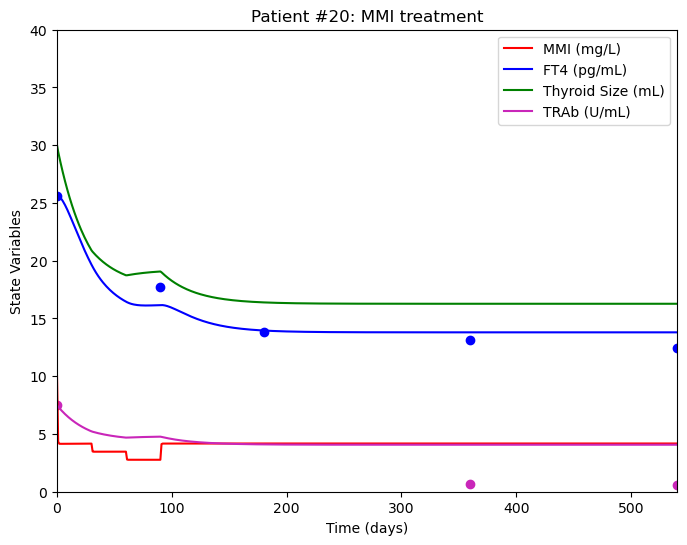

In [6]:
E_0 = (10,25.63,30,7.5,MMI_dose(dose20))
sol = th.dose_sim(E_0, p, dose20)
th.plot_dosing(sol,dose20,title = "Patient #20: MMI treatment", subs = False)

days = [0,90,180,360,540]
levels = [[25.63,17.7,13.8,13.14,12.46],[7.5,None,None,0.7,0.6]]
plt.scatter(days,levels[0], c='b')
plt.scatter(days,levels[1], color="#c926b9")
plt.show()

#### Patient 70

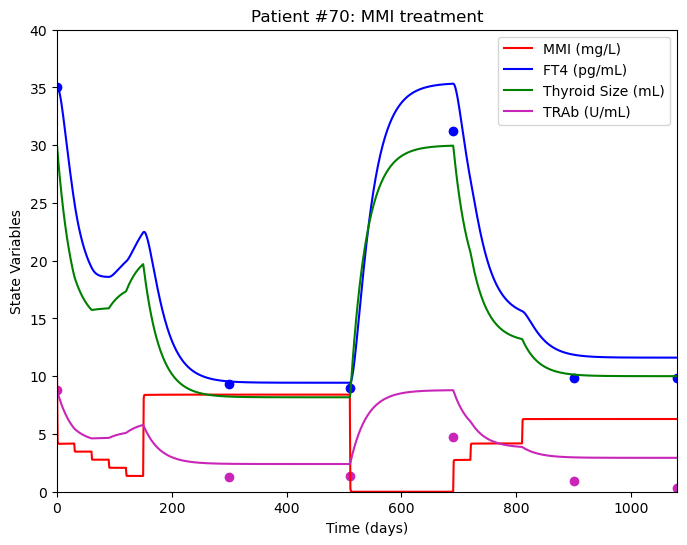

In [7]:
p = th.initialize_pandiyan(patient=70)
dose70 = [[30,25,20,15,10,5,0,20,10,5],[30,60,90,120,150,510,690,720,810,1080]]
E_0 = (10,35.04,30,8.8,MMI_dose(dose70))
sol = th.dose_sim(E_0, p, dose70)
th.plot_dosing(sol,dose70,title = "Patient #70: MMI treatment", subs = False)
levels = [[35.04,9.3,8.97,31.2,9.87,9.87],[8.8,1.3,1.4,4.7,0.9,0.3]]
days = [0,300,510,690,900,1080]
plt.scatter(days,levels[0], c='b')
plt.scatter(days,levels[1], color="#c926b9")
plt.show()

### Nonlinear Least Squares Fitting
---
Sorry for the mess, will clean up code later

In [8]:
def initialize_optimization(E0):
    k_b, k_d = 0.06, 5
    fixed,_ = th.initialize_pandiyan(optim=True)
    k_1,k_2,k_4,k_5,k_6,k_8,k_a = fixed
    k_3 = fixed[2]*E0[1]*(k_d+E0[3])
    k_7 = fixed[5]*E0[3]
    N = E0[3]/E0[2]
    p = [k_1,k_2,k_3,k_4,k_5,k_6,k_7,k_8,k_a,k_b,k_d,N]

    return p

In [9]:
# Residuals function
def err(optParams, E0, dose, days, levels, printing = False):
    # Interpolate missing values in patient data with 
    levels[0] = pd.Series(levels[0]).interpolate().tolist()
    levels[1] = pd.Series(levels[1]).interpolate().tolist()
    p = initialize_optimization(E0)
    p[2],p[6],p[9],p[10],p[11]  = optParams[0], optParams[1], optParams[2], optParams[3], optParams[4]
    # return (p-th.initialize_pandiyan()) # check line
    prediction = th.dose_sim(E0,p,dose)
    FT4residual = 0
    TRAbresidual = 0
    for i, day in enumerate(days):
        if i == 0:
            pass
        else:
            FT4residual += (prediction[day][1]-levels[0][i])
            TRAbresidual += (prediction[day][3]-levels[1][i])
            if printing:
                print(f'Day: {day}  \t FT4 Residual: {FT4residual:.4f} = ({prediction[day][1]:.2f}-{levels[0][i]:.2f})\t TRAb Residual: {TRAbresidual:.2f} = ({prediction[day][3]:.2f}-{levels[1][i]:.2f})')
            residuals = np.array([FT4residual, TRAbresidual])
        
    return residuals

def NLLS_estimation(initial_guess, E_0, dose, days, levels, loss = 'linear', bounds = ([0, 0, 3, 0.05, 0], [0.4, 1, 12, 0.1, 1]), printing = False):
    optims = least_squares(err, initial_guess, loss = loss,
                       args=[E_0,dose,days,levels, printing], 
                       method='trf', bounds=bounds)
    parameters = optims.x
    optimality = optims.optimality
    cost = optims.cost
    return parameters, optimality, cost

def R2(sol, levels):
    # Interpolate missing values in patient data with 
    levels[0] = pd.Series(levels[0]).interpolate().tolist()
    levels[1] = pd.Series(levels[1]).interpolate().tolist()
    FT4residual = np.zeros(len(levels[0]))
    TRAbresidual = np.zeros(len(levels[0]))
    for i, day in enumerate(days):
        if i == 0:
            pass
        else:
            FT4residual[i] = (sol[day][1]-levels[0][i])
            TRAbresidual[i] = (sol[day][3]-levels[1][i])
            #print(f'Day: {day}  \t FT4 Residual: {FT4residual[i]:.4f} = ({sol[day][1]:.2f}-{levels[0][i]:.2f})\t TRAb Residual: {TRAbresidual[i]:.2f} = ({sol[day][3]:.2f}-{levels[1][i]:.2f})')

    meanFT4 = np.mean(levels[0])
    SSresFT4 = np.sum(FT4residual**2)
    SStotFT4 = np.sum((levels[0] - meanFT4)**2)
    R2FT4 = 1 - SSresFT4/SStotFT4

    meanTRAb = np.mean(levels[1])
    SSresTRAb = np.sum(TRAbresidual**2)
    SStotTRAb = np.sum((levels[1] - meanTRAb)**2)
    R2TRAb = 1 - SSresTRAb/SStotTRAb
        
    return R2FT4, R2TRAb
    

#### PATIENT 20

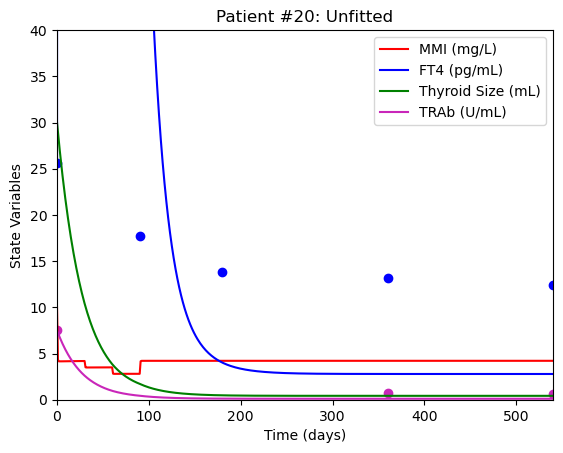

In [10]:
# Display unfitted patient 20
E_0 = (10,25.63,30,7.5,MMI_dose(dose20)) #have to get this value from paper
p_20_initial = initialize_optimization(E_0)

sol = th.dose_sim(E_0, p_20_initial, dose20)
th.plot_dosing(sol,dose20,title = "Patient #20: Unfitted", subs = True)

days = [0,90,180,360,540]
levels = [[25.63,17.7,13.8,13.14,12.46],[7.5,None,None,0.7,0.6]]
plt.scatter(days,levels[0], c='b')
plt.scatter(days,levels[1], color="#c926b9")
plt.show()

In [11]:
# Patient 20 start
initial_guess = [0.119,0.875,3.01,0.051,0.833]
author_params = [0.08535, 0.2625, 4.95, 0.06, 0.250]
E_0 = (10,25.63,30,7.5,MMI_dose(dose20))
days = [0,90,180,360,540]
levels = [[25.63,17.7,13.8,13.14,12.46],[7.5,None,None,0.7,0.6]]

In [12]:
# Parameter Estimation
# NOTE: if you get an ODE too much work message rerun the cell 
LSOptParams, optimality, cost = NLLS_estimation(initial_guess, E_0, dose20, days, levels, loss='linear')

c:\Users\Aidan\anaconda3\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [13]:
printParams = lambda p: print(f'k3 = {p[0]:.3f}\tk7 = {p[1]:.3f}\tkb = {p[2]:.3f}\tkd = {p[3]:.3f}\tN = {p[4]:.3f}')
print("Initial guess: Patient 20")
_, variableParams = th.initialize_pandiyan(optim=True)
printParams(variableParams)
print("Estimated parameters: Patient 20")
printParams(LSOptParams)
print("Author Params")
authorParams = [0.08535, 0.2625, 4.95, 0.06, 0.250]
printParams(authorParams)

Initial guess: Patient 20
k3 = 0.119	k7 = 0.875	kb = 1.500	kd = 0.050	N = 0.833
Estimated parameters: Patient 20
k3 = 0.330	k7 = 0.186	kb = 3.003	kd = 0.054	N = 0.546
Author Params
k3 = 0.085	k7 = 0.263	kb = 4.950	kd = 0.060	N = 0.250


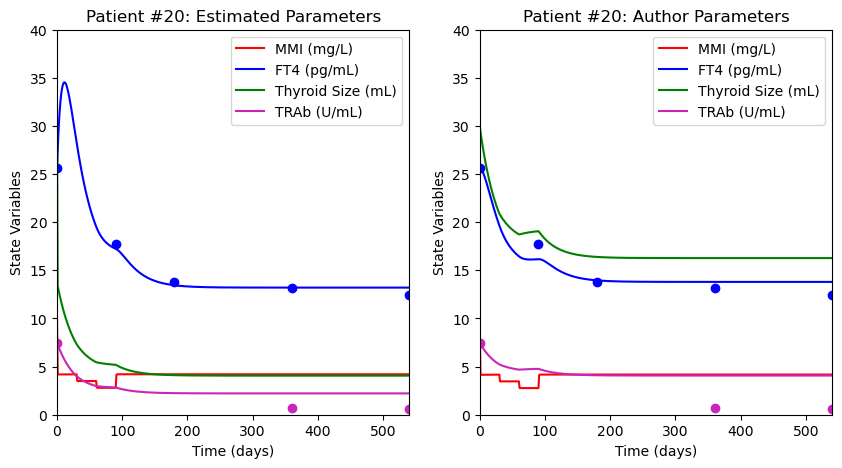

In [14]:
dose20 = [[30,25,20,10,5,5],[30,60,90,180,360,540]]

plt.figure(figsize=(10,5))
# Plot simulation with optimized parameter values
plt.subplot(1,2,1)
p=np.zeros(12)
fixed, _ = th.initialize_pandiyan(optim=True)
p[0],p[1],p[3],p[4],p[5],p[7],p[8]=fixed[0],fixed[1],fixed[2],fixed[3],fixed[4],fixed[5],fixed[6]
p[2],p[6],p[9],p[10],p[11]  = LSOptParams[0], LSOptParams[1], LSOptParams[2], LSOptParams[3], LSOptParams[4]
sol_exp = th.dose_sim(E_0, p, dose20)
th.plot_dosing(sol_exp,dose20,title = "Patient #20: Estimated Parameters", subs = True)

days = [0,90,180,360,540]
levels = [[25.63,17.7,13.8,13.14,12.46],[7.5,None,None,0.7,0.6]]
plt.scatter(days,levels[0], c='b')
plt.scatter(days,levels[1], color="#c926b9")

plt.subplot(1,2,2)
p = th.initialize_pandiyan(patient=20)
dose20 = [[30,25,20,10,5,5],[30,60,90,180,360,540]]
E_0 = (10,25.63,30,7.5,MMI_dose(dose20))
sol = th.dose_sim(E_0, p, dose20)
th.plot_dosing(sol,dose20,title = "Patient #20: Author Parameters", subs = True)

days = [0,90,180,360,540]
levels = [[25.63,17.7,13.8,13.14,12.46],[7.5,None,None,0.7,0.6]]
plt.scatter(days,levels[0], c='b')
plt.scatter(days,levels[1], color="#c926b9")
plt.show()


In [15]:
R2FT4, R2TRAb = R2(sol,levels)
print(f'Optimality: {optimality:.4f}\t Cost: {cost:.4f}')
print(f'R2 - FT4: {R2FT4:.4f}\t R2 - TRAb: {R2TRAb:.4f}')

Optimality: 0.0000	 Cost: 0.0000
R2 - FT4: 0.9614	 R2 - TRAb: 0.2992
